In [6]:
import pandas as pd
import numpy as np
import torch
from phd import get_phd
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import modeling_utils
if not hasattr(modeling_utils, "ALL_PARALLEL_STYLES") or modeling_utils.ALL_PARALLEL_STYLES is None:
    modeling_utils.ALL_PARALLEL_STYLES = ["tp", "none", "colwise", 'rowwise']


model_name = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)



class AddDeleteWordAnalyzer:
    def __init__(self, tokenizer, number_of_texts=3, number_of_words_per_text=15, n_tries=10):
        self.tokenizer = tokenizer
        self.number_of_texts = number_of_texts
        self.number_of_words_per_text = number_of_words_per_text
        self.n_tries = n_tries

    def delete_word(self, texts):
        word2diff_phd = dict()
        for _ in tqdm(range(self.number_of_texts)): # 40
            print(len(texts))
            text = texts[np.random.choice(len(texts))]
            tokenized = tokenizer(text)['input_ids'][1:-1]
            df_example = pd.DataFrame({'text': [text]})
            true_phd = get_phd(df_example)[0][0]
            entropies = self.get_entropy_of_text(text)
            
            for i in np.random.choice(len(tokenized), size=self.number_of_words_per_text): # 10
                new_text = tokenizer.decode(tokenized[:i] + tokenized[i + 1:])# ' '.join(tokenized[:i] + tokenized[i + 1:])
                df_new = pd.DataFrame({'text': [new_text]})
                new_phd = get_phd(df_new, n_tries=self.n_tries)[0][0]
                word2diff_phd[tokenized[i]] = true_phd - new_phd, text, entropies[i]
            
        df_stats2 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')
        return df_stats2

    def get_entropy_of_text(self, text):
        inputs = self.tokenizer(text, return_tensors="pt")
        output = model(**inputs)
        probs = torch.softmax(output.logits.float(), dim=1)
        raw_entropy = -(probs * torch.log(probs)).detach().data.sum(axis=-1)
        result = list(
            zip(
                raw_entropy.reshape(-1).tolist(),
                [tokenizer.decode([token_id]) for token_id in inputs['input_ids'].reshape(-1)]
            )
        )
        return result

In [7]:
df = pd.read_parquet("data/train-00000-of-00009.parquet")
analyzer = AddDeleteWordAnalyzer(tokenizer)
human_texts = df.query("model == 'human'")['generation'].values.tolist()
llm_texts = df.query("model != 'human'")['generation'].values.tolist()

In [16]:
human_stats = analyzer.delete_word(human_texts)


  0%|                                                     | 0/3 [00:00<?, ?it/s]

21116



100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.14s/it]

100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 27.00s/it]

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.33s/it]

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.31s/it]

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.38s/it]

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.44s/it]

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.77s/it]

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.63s/it]

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 28.00s/it]

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.88s/it]

100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.32s/it]

100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.32s/it]

100%|██████████

21116



100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]

100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.10s/it]

100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.76s/it]

100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.91s/it]

100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.70s/it]

100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.68s/it]

100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.77s/it]

100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.63s/it]

100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.98s/it]

100%|█████████████████████████████████████████████| 1/1 [00:32<00:00, 32.04s/it]

100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.91s/it]

100%|█████████████████████████████████████████████| 1/1 [00:32<00:00, 32.01s/it]

100%|██████████

21116



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.83s/it]

100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.60s/it]

100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.77s/it]

100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.64s/it]

100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.75s/it]

100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.90s/it]

100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.69s/it]

100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.61s/it]

100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.45s/it]

100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.84s/it]

100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.96s/it]

100%|██████████

In [17]:
# 3 text 15 samples 100 tries
human_stats['diff_phd_value'] = human_stats['diff_phd'].apply(lambda x: x[0])
human_stats['entropy'] = human_stats['diff_phd'].apply(lambda x: x[2][0])
human_stats[['diff_phd_value', 'entropy']].corr()

,diff_phd_value,entropy
diff_phd_value,1.000000,0.114667
entropy,0.114667,1.000000


In [19]:
human_stats['text'] = human_stats['diff_phd'].apply(lambda x: x[1])

In [28]:
human_stats.sort_values(by='text').iloc[:13, :][['diff_phd_value', 'entropy']].corr()

,diff_phd_value,entropy
diff_phd_value,1.000000,0.104097
entropy,0.104097,1.000000


In [35]:
human_stats.sort_values(by='text').iloc[13:28, :][['diff_phd_value', 'entropy']].corr()

,diff_phd_value,entropy
diff_phd_value,1.000000,0.005366
entropy,0.005366,1.000000


In [32]:
human_stats.sort_values(by='text').iloc[13:28, :]

,diff_phd,diff_phd_value,entropy,text
11,"(0.18132130237780686, The Amazing Maurice is a...",0.181321,1702.501709,The Amazing Maurice is a sentient cat who lead...
14242,"(0.3972139855624235, The Amazing Maurice is a ...",0.397214,3710.478516,The Amazing Maurice is a sentient cat who lead...
54437,"(0.32868643098476547, The Amazing Maurice is a...",0.328686,1629.284058,The Amazing Maurice is a sentient cat who lead...
6199,"(0.3179930360771763, The Amazing Maurice is a ...",0.317993,2192.304688,The Amazing Maurice is a sentient cat who lead...
902,"(0.29365844362233773, The Amazing Maurice is a...",0.293658,791.112915,The Amazing Maurice is a sentient cat who lead...
722,"(0.2283592644532053, The Amazing Maurice is a ...",0.228359,2930.441895,The Amazing Maurice is a sentient cat who lead...
4332,"(0.21113004239530042, The Amazing Maurice is a...",0.211130,1127.702393,The Amazing Maurice is a sentient cat who lead...
33168,"(0.20375713858670075, The Amazing Maurice is a...",0.203757,2292.721680,The Amazing Maurice is a sentient cat who lead...
36533,"(0.13318295813868097, The Amazing Maurice is a...",0.133183,5973.013672,The Amazing Maurice is a sentient cat who lead...
34917,"(0.11322806732148827, The Amazing Maurice is a...",0.113228,3305.260254,The Amazing Maurice is a sentient cat who lead...


In [34]:
human_stats.sort_values(by='text').iloc[28:, :][['diff_phd_value', 'entropy']].corr()

,diff_phd_value,entropy
diff_phd_value,1.000000,0.108697
entropy,0.108697,1.000000


<Axes: >

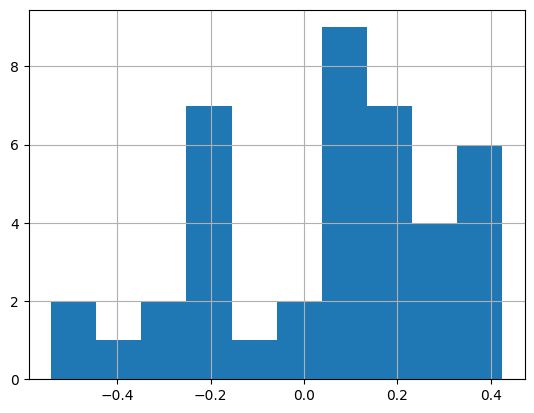

In [36]:
human_stats['diff_phd_value'].hist(bins=10)

In [11]:
# 1 text 15 samples 50 tries
human_stats['diff_phd_value'] = human_stats['diff_phd'].apply(lambda x: x[0])
human_stats['entropy'] = human_stats['diff_phd'].apply(lambda x: x[2][0])
human_stats[['diff_phd_value', 'entropy']].corr()

,diff_phd_value,entropy
diff_phd_value,1.000000,-0.579499
entropy,-0.579499,1.000000


In [40]:
import pickle


with open("human_# 3 text 15 samples 100 tries .pickle", 'wb') as fd:
    pickle.dump(human_stats, fd)

In [34]:
import pickle 

with open("human_stats.pickle", "wb") as fd:
    pickle.dump(human_stats, fd)

In [3]:
import pickle 


with open("human_stats.pickle", "rb") as fd:
    human_stats = pickle.load(fd)

In [35]:
import pickle 

with open("llm_stats.pickle", "wb") as fd:
    pickle.dump(llm_stats, fd)

In [4]:
import pickle 


with open("llm_stats.pickle", "rb") as fd:
    llm_stats = pickle.load(fd)

In [8]:
llm_stats = analyzer.delete_word(llm_texts)

  0%|                                                     | 0/3 [00:00<?, ?it/s]

413577



100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.52s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.84s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

100%|██████████

413577



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.84s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

100%|██████████

413577



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

100%|██████████

In [10]:
llm_stats
# 1 text 15 samples 50 tries
llm_stats['diff_phd_value'] = llm_stats['diff_phd'].apply(lambda x: x[0])
llm_stats['entropy'] = llm_stats['diff_phd'].apply(lambda x: x[2][0])
llm_stats[['diff_phd_value', 'entropy']].corr()

,diff_phd_value,entropy
diff_phd_value,1.000000,0.148827
entropy,0.148827,1.000000


<Axes: >

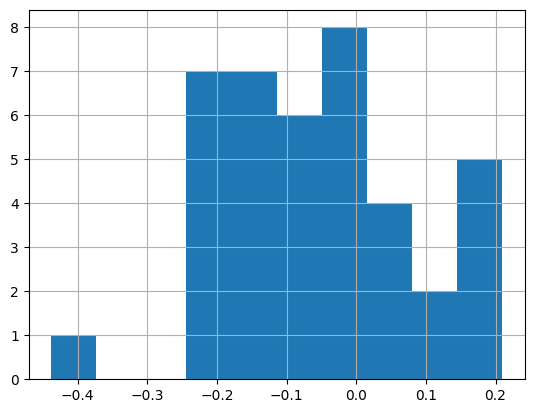

In [11]:
llm_stats['diff_phd_value'].hist(bins=10)

In [12]:
import pickle


with open("llm_# 3 text 15 samples 10 tries .pickle", 'wb') as fd:
    pickle.dump(llm_stats, fd)

In [ ]:
print(1)

<Axes: >

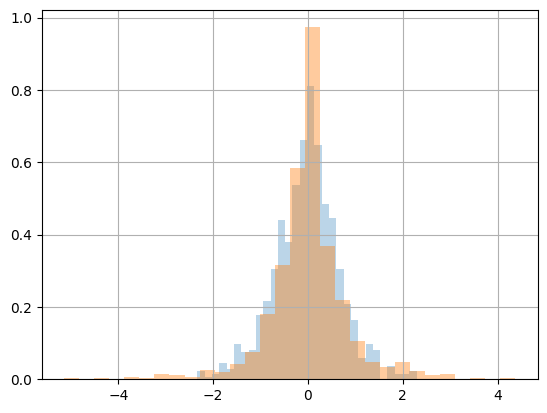

In [13]:
human_stats['diff_phd_value'] = human_stats['diff_phd'].apply(lambda x: x[0])
human_stats['diff_phd_value'].hist(bins=30, alpha=0.3, density=True)
llm_stats['diff_phd_value'] = llm_stats['diff_phd'].apply(lambda x: x[0])
llm_stats['diff_phd_value'].hist(bins=30, alpha=0.4, density=True)

In [36]:
from langchain_ollama import ChatOllama


model_id = "Qwen/Qwen3-1.7B"
llm = ChatOllama(
        #    model=model_id # TODO: Загрузите модель в базовый класс LangChain LLM
    model="Qwen/Qwen3-1.7B"
)

In [38]:
llm

ChatOllama(model='Qwen/Qwen3-1.7B')

In [ ]:
~/.local/lib/python3.10/site-packages/langchain_core/language_models/chat_models.py

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer


name_small = "Qwen/Qwen3-0.6B"
model_1b = AutoModelForCausalLM.from_pretrained(name_small)
tokenizer = AutoTokenizer.from_pretrained(model_1b)

HFValidationError: Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96: 'Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
      )
    )
    (norm): Qwen3RMSNorm((1024,), eps=1e-06)
    (rotary_emb): Qwen3RotaryEmbedding()
  )
  (lm_head): Linear(in_features=1024, out_features=151936, bias=False)
)'.

tokenizer_config.json:   0%|          | 0.00/9.73k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [93]:
result

{'In': 17212.50390625,
 ' decimal': 11909.56640625,
 ',': 13758.966796875,
 ' ': 15630.396484375,
 '1': 14006.720703125,
 ' +': 12386.314453125,
 ' =': 11112.3662109375,
 '2': 12467.447265625,
 '.': 16577.08203125,
 ' But': 21412.568359375,
 ' how': 8339.4462890625,
 ' does': 16115.833984375,
 ' that': 10088.302734375,
 ' translate': 12013.2529296875,
 ' to': 18076.630859375,
 ' base': 8488.306640625,
 '?': 8337.84375,
 ' Well': 14279.7255859375,
 ' in': 8887.9443359375,
 ' binary': 6289.33251953125}

In [75]:
(probs * torch.log(probs)).detach().data.sum(axis=-1)

tensor([[-23869.3281, -12343.6689,  -8613.9189, -11498.9814, -13245.0820,
          -8644.3516, -11733.2510,  -9959.1279, -11789.9854,  -6067.7529,
         -11440.5996, -24376.4180, -15558.9209,  -9977.2939,  -5527.4424,
          -7245.9502,  -4809.2744,  -5951.1528,  -6038.8965]])

In [10]:
import torch


inputs['input_ids'] = torch.tensor(inputs['input_ids'])

In [8]:
tokenizer

Signature:     
tokenizer(
    text: Union[str, List[str], List[List[str]], NoneType] = None,
    text_pair: Union[str, List[str], List[List[str]], NoneType] = None,
    text_target: Union[str, List[str], List[List[str]], NoneType] = None,
    text_pair_target: Union[str, List[str], List[List[str]], NoneType] = None,
    add_special_tokens: bool = True,
    padding: Union[bool, str, transformers.utils.generic.PaddingStrategy] = False,
    truncation: Union[bool, str, transformers.tokenization_utils_base.TruncationStrategy, NoneType] = None,
    max_length: Optional[int] = None,
    stride: int = 0,
    is_split_into_words: bool = False,
    pad_to_multiple_of: Optional[int] = None,
    padding_side: Optional[str] = None,
    return_tensors: Union[str, transformers.utils.generic.TensorType, NoneType] = None,
    return_token_type_ids: Optional[bool] = None,
    return_attention_mask: Optional[bool] = None,
    return_overflowing_tokens: bool = False,
    return_special_tokens_mask: bool